In [43]:
import torch
import torchaudio
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import json
from datetime import timedelta, datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd

In [44]:
torchaudio.list_audio_backends()

['soundfile']

In [45]:
audiofile = Path('/home/musa/who-opened-the-door/data/april_15th_7h.ogg')
labelsfile = Path('/home/musa/who-opened-the-door/data/april_15.json')
# audiofile = Path('/home/musa/who-opened-the-door/data/april_12_7h.ogg')
# labelsfile = Path('/home/musa/who-opened-the-door/data/april_12.json')

In [46]:
metadata = torchaudio.info(str(audiofile))
sample_rate = metadata.sample_rate
n_frames = metadata.num_frames
n_channels = metadata.num_channels
encoding = metadata.encoding # VORBIS for .ogg files
sample_rate, n_frames, n_channels, encoding

(44100, 1111320896, 2, 'VORBIS')

In [47]:
labels_map = {
    'None': 0,
    'Alireza': 1,
    'Lex': 2,
    'Ali': 3,
    'Hamed': 4,
    'Valafar': 5,
    'Andrew': 6,
    'Chris': 7,
    'Musa': 8,
    'Other': 9
}

In [48]:
class AudioDataset(Dataset):
    def __init__(self, audio_file, labelsfile, metadata=None, chunk_size=50_000_000):
        audio_file = str(audio_file)
        self.audio_file = audio_file
        self.chunk_size = chunk_size
        
        if not metadata:
            metadata = torchaudio.info(audio_file)
        self.sample_rate = metadata.sample_rate
        
        if self.chunk_size is None:
            self.chunk_size = metadata.num_frames
            
        self.num_chunks = metadata.num_frames // self.chunk_size

        labels = json.load(open(labelsfile))
        self.y = torch.zeros(metadata.num_frames, dtype=torch.float32)
        for label in labels:
            start = label['start']
            person = label['label'] # for now, just binary classification so ignore
            d = datetime.strptime(start, '%H:%M:%S')
            d = timedelta(hours=d.hour, minutes=d.minute, seconds=d.second)
            start_time = int(d.total_seconds() * metadata.sample_rate)
            end_time = start_time + 8 * metadata.sample_rate # 5 seconds
            self.y[start_time:end_time] = float(labels_map[person])

    def __len__(self):
        return self.num_chunks

    def __getitem__(self, idx):
        start_frame = idx * self.chunk_size
        audio_chunk, _ = torchaudio.load(self.audio_file, frame_offset=start_frame, num_frames=self.chunk_size)
        labels = self.y[start_frame:start_frame+self.chunk_size]
        return audio_chunk, labels

In [49]:
chunk_size = 100_000_000
audioDataset = AudioDataset(audiofile, labelsfile, metadata, chunk_size)
wave, labels = audioDataset[1]
# number of mb in the audio file:
len(wave.flatten()) * wave.element_size() / 1e6
last_chunk = -1

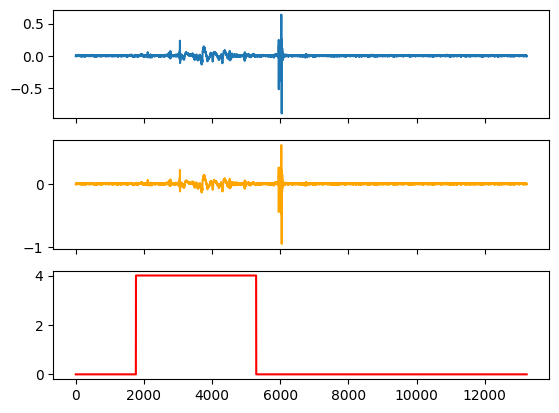

In [50]:
fig,axes = plt.subplots(3, sharex=True)
sample_rate = audioDataset.sample_rate
h = 3
m = 30
s = 0
start_time = (h*3600 + m*60 + s) * sample_rate
chunk = start_time // chunk_size
if chunk != last_chunk:
    wave, labels = audioDataset[chunk]
    last_chunk = chunk
start_time = start_time % chunk_size
axes[0].plot(wave[0,start_time:start_time+30*sample_rate:100].numpy())
axes[1].plot(wave[1,start_time:start_time+30*sample_rate:100].numpy(), color='orange')
axes[2].plot(labels[start_time:start_time+30*sample_rate:100].numpy(), color='red')

In [51]:
# Save as tensors
X = []
y = []
for i in tqdm(range(len(audioDataset))):
    wave, labels = audioDataset[i]
    wave = wave[:,::100] # downsample by 100
    labels = labels[::100]
    X.append(wave)
    y.append(labels)
X = torch.cat(X, dim=1)
y = torch.cat(y)

outdir = Path('/home/musa/who-opened-the-door/data/april_15_dec100')
outdir.mkdir(exist_ok=True)
torch.save(X, outdir / 'X.pt')
torch.save(y, outdir / 'y.pt')

100%|██████████| 11/11 [00:22<00:00,  2.07s/it]


# Step 2

In [ ]:
# import math

# class WindowedAudioDataset(Dataset):
#     def __init__(self, audio_file, labelsfile, window_size, stride, idxs=None):
#         audio_file = str(audio_file)
#         self.audio_file = audio_file
#         self.window_size = window_size
#         self.stride = stride        

#         metadata = torchaudio.info(audio_file)
        
#         self.idxs = idxs
#         self.len_ = len(idxs) if idxs else math.ceil(metadata.num_frames / stride)

#         labels = json.load(open(labelsfile))
#         self.y = torch.zeros(metadata.num_frames, dtype=torch.int64)
#         for label in labels:
#             start = label['start']
#             person = label['label'] # for now, just binary classification so ignore
#             d = datetime.strptime(start, '%H:%M:%S')
#             d = timedelta(hours=d.hour, minutes=d.minute, seconds=d.second)
#             start_time = int(d.total_seconds() * metadata.sample_rate)
#             end_time = start_time + 5 * metadata.sample_rate # 5 seconds
#             self.y[start_time:end_time] = 1

#     def __len__(self):
#         return self.len_

#     def __getitem__(self, idx):
#         if self.idxs:
#             idx = self.idxs[idx]
#         start_frame = idx * self.stride
#         audio_chunk, _ = torchaudio.load(
#             self.audio_file,
#             frame_offset=start_frame,
#             num_frames=self.window_size
#         )
#         if audio_chunk.shape[1] < self.window_size:
#             audio_chunk = torch.cat([audio_chunk, torch.zeros(2, self.window_size - audio_chunk.shape[1])], dim=1)
#         labels = self.y[start_frame:start_frame+self.window_size].mode().values
#         return audio_chunk, labels

In [ ]:
# stride = 1*sample_rate
# window_size = 5*sample_rate
# idxs = list(range(0, math.ceil(metadata.num_frames / stride)))
# train_idxs, val_idxs = train_test_split(idxs, test_size=0.2)
# train_idxs.__len__()
# train_dataset = WindowedAudioDataset(audiofile, labelsfile, window_size, stride, train_idxs)
# val_dataset = WindowedAudioDataset(audiofile, labelsfile, window_size, stride, val_idxs)
# trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# testloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [52]:
import math

class WindowedAudioDataset(Dataset):
    def __init__(self, X, y, window_size, stride):
        self.window_size = window_size
        self.stride = stride

        self.X = X
        self.y = y
        self.y = torch.where(y != 0, torch.ones_like(y), torch.zeros_like(y))
        self.len = math.ceil(self.X.shape[1] / self.stride)

        self.X = torch.cat([self.X, torch.zeros(X.shape[0], self.window_size-1)], dim=1)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        if idx >= self.len:
            raise IndexError()
        return (
            self.X[:,(idx*self.stride):(idx*self.stride)+self.window_size],
            self.y[(idx*self.stride):(idx*self.stride)+self.window_size].mode().values.unsqueeze(0)
        )
    
class DataSetSplit(Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = idxs

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, idx):
        return self.dataset[self.idxs[idx]]

In [54]:
outdirs = [
    Path('/home/musa/who-opened-the-door/data/april_12_dec100'),
    Path('/home/musa/who-opened-the-door/data/april_15_dec100')
]

sample_rate = 44100 // 100
stride = sample_rate // 16       
window_size = 10*sample_rate # cant be more than 11 seconds since event is 6 seconds long

Xload = []
yload = []
for outdir in outdirs:
    Xload.append(torch.load(outdir / 'X.pt'))
    yload.append(torch.load(outdir / 'y.pt'))
    print(Xload[-1].shape, yload[-1].shape)
Xload = torch.cat(Xload, dim=1)
yload = torch.cat(yload)

dataset = WindowedAudioDataset(Xload, yload, window_size, stride)
print(len(dataset))

test_size = 0.25
idxs = list(range(len(dataset)))
# train_idxs, val_idxs = train_test_split(idxs, test_size=0.25)
train_idxs = idxs[:-int(len(dataset)*test_size)]
val_idxs = idxs[-int(len(dataset)*test_size):]
print(len(train_idxs), len(val_idxs))

train_dataset = DataSetSplit(dataset, train_idxs)
val_dataset = DataSetSplit(dataset, val_idxs)

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

torch.Size([2, 11000000]) torch.Size([11000000])
torch.Size([2, 11000000]) torch.Size([11000000])
814815
611112 203703


In [64]:
from torch import nn
import torch.nn.functional as F

class AudioNetConv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(2, 4, kernel_size=9, stride=1, padding='same')
        self.bn1 = nn.BatchNorm1d(4)
        # self.maxpool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        # self.conv2 = nn.Conv1d(4, 8, kernel_size=3, stride=1, padding='same')
        # self.bn2 = nn.BatchNorm1d(8)
        # self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        # self.conv3 = nn.Conv1d(8, 16, kernel_size=3, stride=1, padding='same')
        # self.bn3 = nn.BatchNorm1d(16)
        self.gp = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(4, 1)
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        # x = self.maxpool1(x)
        # x = F.relu(self.bn2(self.conv2(x)))
        # x = self.maxpool2(x)
        # x = F.relu(self.bn3(self.conv3(x)))
        x = self.gp(x)
        x = x.squeeze(-1)
        x = self.fc1(x)
        return x

In [56]:
from torch import nn
import torch.nn.functional as F

class AudioNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size*2, 8)
        self.fc2 = nn.Linear(8, 1)
    def forward(self, x):
        x = x.flatten(1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [57]:
sum_pos = 0
sum_neg = 0
for X,y in trainloader:
    sum_pos += y.sum()
    sum_neg += (y == 0).sum()
weight = sum_neg / sum_pos

In [66]:
device = 'cuda:0'
# model = nn.DataParallel(AudioNet(window_size).to(device))
model = nn.DataParallel(AudioNetConv().to(device))
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=weight)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [67]:
from sklearn.metrics import f1_score

train_losses = []
val_losses = []
best_f1 = 0
for epoch in (pbar := tqdm(range(100))):
    train_loss = 0
    model.train()
    for X,y in trainloader:
        X = X.to(device)
        y = y.to(device)
        logits = model(X)
        loss = criterion(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        train_loss += loss.item()
    train_losses.append(train_loss / len(trainloader))

    model.eval()
    with torch.no_grad():
        val_loss = 0
        y_true = []
        y_pred = []
        for X,y in valloader:
            y_true.append(y)
            X = X.to(device)
            y = y.to(device)
            logits = model(X)
            val_loss += criterion(logits, y).item()
            y_pred.append(torch.round(F.sigmoid(logits)))
        val_losses.append(val_loss / len(valloader))
        y_true = torch.cat(y_true).cpu().numpy()
        y_pred = torch.cat(y_pred).cpu().numpy()
        f1 = f1_score(y_true, y_pred, average='binary', zero_division=0)
    
    if f1 > best_f1:
        best_f1 = f1
        print(f'New best f1: {f1}')
        torch.save(model.state_dict(), 'model.pt')

    pbar.set_postfix({'loss': train_losses[-1], 'val_loss': val_losses[-1], 'f1': f1, 'predsum': y_pred.sum()})

  1%|          | 1/100 [01:07<1:50:41, 67.09s/it, loss=0.832, val_loss=0.451, f1=0.342, predsum=5696.0]

New best f1: 0.3420171736282928


  2%|▏         | 2/100 [02:14<1:50:15, 67.50s/it, loss=0.325, val_loss=0.295, f1=0.456, predsum=3952.0]

New best f1: 0.45601716403354786


  3%|▎         | 3/100 [03:21<1:48:35, 67.17s/it, loss=0.234, val_loss=0.239, f1=0.459, predsum=3937.0]

New best f1: 0.4593114241001565


  6%|▌         | 6/100 [06:37<1:42:54, 65.68s/it, loss=0.162, val_loss=0.205, f1=0.46, predsum=3933.0] 

New best f1: 0.4600626468285043


  7%|▋         | 7/100 [07:41<1:41:17, 65.35s/it, loss=0.152, val_loss=0.198, f1=0.487, predsum=3649.0]

New best f1: 0.48714759535655056


 13%|█▎        | 13/100 [14:23<1:37:10, 67.02s/it, loss=0.119, val_loss=0.18, f1=0.487, predsum=3635.0] 

New best f1: 0.48731808731808735


 15%|█▌        | 15/100 [16:36<1:34:45, 66.89s/it, loss=0.117, val_loss=0.212, f1=0.49, predsum=3516.0] 

New best f1: 0.49030057557024087


 23%|██▎       | 23/100 [25:32<1:26:08, 67.12s/it, loss=0.113, val_loss=0.177, f1=0.5, predsum=3468.0]  

New best f1: 0.5001076889941848


 29%|██▉       | 29/100 [33:20<1:21:37, 68.98s/it, loss=0.107, val_loss=0.144, f1=0.44, predsum=4169.0] 


KeyboardInterrupt: 

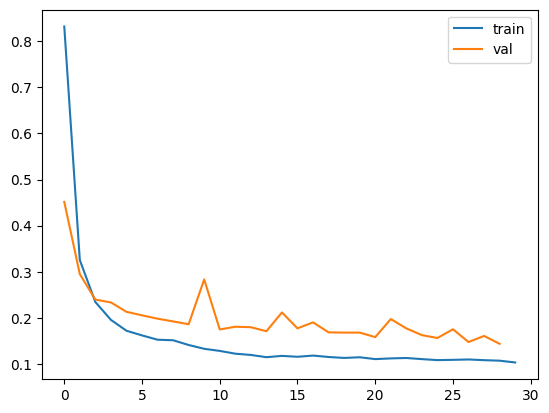

In [68]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()

0.33477508650519033 0.9880851063829788 0.5001076889941848 None


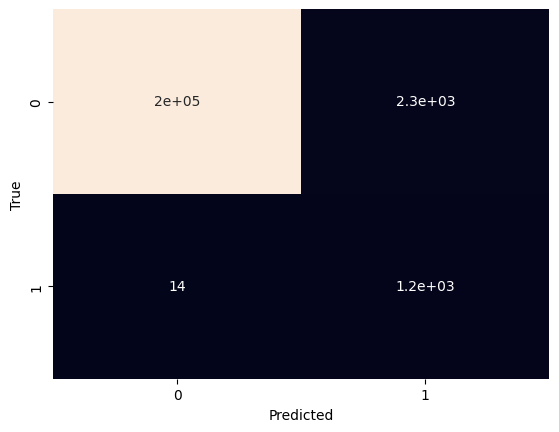

In [69]:
# evaluate
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns

model.load_state_dict(torch.load('model.pt'))
model.eval()
with torch.no_grad():
    y_true = []
    y_pred = []
    val_X = []
    for X,y in valloader:
        X = X.to(device)
        y = y.to(device)
        logits = model(X)
        y_true.append(y.cpu())
        y_pred.append(torch.round(F.sigmoid(logits)).cpu())
        val_X.append(X.cpu())
    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()
    val_X = torch.cat(val_X).numpy()
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
cm = confusion_matrix(y_true, y_pred)

print(precision, recall, f1, _)
sns.heatmap(cm, annot=True, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True');

In [54]:
np.where(y_true == 1)[0]

array([12430, 12431, 12432, 12433, 12434, 12435, 12436, 12437, 12438,
       12439, 12440, 12441, 12442, 12443, 12444, 12445, 12446, 12447,
       12448, 12449, 12450, 12451, 12452, 12453, 12454, 12455, 12456,
       12457, 12458, 12459, 12460, 12461, 12462, 12463, 12464, 12465,
       12466, 12467, 12468, 12469, 12470, 12471, 12472, 12473, 12474,
       12475, 12476, 12477, 12478, 12479, 12480, 12481, 12482, 12483,
       12484, 12485, 12486, 12487, 12488, 12489, 12490, 12491, 12492,
       12493, 12494, 12495, 12496, 12497, 12498, 12499, 12500, 12501,
       12502, 12503, 12504, 12505, 12506, 12507, 12508, 12509, 12510,
       12511, 12512, 12513, 12514, 12515, 12516, 12517, 12518, 12519,
       12520, 12521, 12522, 12523, 12524, 12525, 12526, 12527, 41797,
       41798, 41799, 41800, 41801, 41802, 41803, 41804, 41805, 41806,
       41807, 41808, 41809, 41810, 41811, 41812, 41813, 41814, 41815,
       41816, 41817, 41818, 41819, 41820, 41821, 41822, 41823, 41824,
       41825, 41826,

In [56]:
import plotly.express as px
i = 12400
dur = 100
df = pd.DataFrame(dict(
    channelA=val_X[i:i+dur,0,window_size//2-stride//2:window_size//2+stride//2+1].flatten(),
    channelB=val_X[i:i+dur,1,window_size//2-stride//2:window_size//2+stride//2+1].flatten(),
    label=np.pad(y_true[i:i+dur], ((0,0),(0, stride-1)), 'edge').flatten(),
    pred=np.pad(y_pred[i:i+dur], ((0,0),(0, stride-1)), 'edge').flatten(),
))
fig = px.line(df[::10], y=['channelA', 'channelB', 'label', 'pred'])
fig.show(renderer='browser')